## Load/import packages

In [95]:
import json
import scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import kerastuner as kt

from tensorflow.keras import Sequential, layers
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.utils import class_weight

from functions import f1, plot_history, arr_replacevalue
from load_features import (
    train_features,
    val_features,
    test_features,
    train_labels,
    val_labels,
    labels_reshaper,
    features_reshaper,
)


from os import listdir
from os.path import splitext
from os.path import join

%matplotlib inline

# Limit GPU memory usage
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Prepare data

## Reshape feautures, labels

In [158]:
# Reshape data to sequence length 150
length = 240
# seq_train_features = features_reshaper(train_features, length)
seq_val_features = features_reshaper(val_features, length)
# seq_test_features = features_reshaper(test_features, length)

# seq_train_labels = labels_reshaper(train_labels, length)
seq_val_labels = labels_reshaper(val_labels, length)

## Compute sample weights

In [3]:
# Convert one-hot encoded labels back to label integers
train_label_ints = np.argmax(seq_train_labels, axis=2)

# Compute class weights with sklearn
class_weights = class_weight.compute_class_weight(
    "balanced", np.unique(train_label_ints), train_label_ints.flatten()
)
d_class_weights = dict(enumerate(class_weights))

# Copy label integer array
arr = train_label_ints.copy()

# Pass a 2D array with shape (samples, sequence_length), to apply a different weight to every timestep of every sample
train_samples_weights = arr_replacevalue(arr, d_class_weights)

C:\Users\ion\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6], y=[0 0 0 ... 6 6 6] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


## Define optimal model

In [5]:
def build_opt_model():
    model = Sequential(name="RNN-LSTM")
    model.add(
        layers.InputLayer(
            input_shape=(seq_train_features.shape[1], seq_train_features.shape[2])
        )
    )
    model.add(layers.LSTM(2048, return_sequences=True, name="LSTM_1"))
    model.add(layers.LayerNormalization())
    model.add(layers.LSTM(256, return_sequences=True, name="LSTM_2"))
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(
        optimizer="adagrad",
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", f1, "AUC"],
    )
    return model


# Other ok models:
# 2048 units (layer 1) + 1024 units (layer 2)+ label_smoothing=0.1 (Sequence length: 120)
# 1024 units (layer 1) + 512 units (layer 2) (Sequence length: 120)
# 2048 units (layer 1) + 1024 units (layer 2) + label_smoothing=0.1 (Sequence length: 60)
# 256 units (1 layer) (Sequence length: 60)
# 2048 units (1 layer) (Sequence length: 60)

# Train + Evaluate model

## Best model results

In [6]:
cnn_rnn_LSTM = build_opt_model()
cnn_rnn_LSTM.summary()

history_best = cnn_rnn_LSTM.fit(
    seq_train_features,
    seq_train_labels,
    sample_weight=train_samples_weights,
    validation_data=(seq_val_features, seq_val_labels),
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_f1", verbose=1, patience=6, restore_best_weights=False
        )
    ],
    verbose=2,
)

Model: "RNN-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_1 (LSTM)                (None, 150, 2048)         54534144  
_________________________________________________________________
layer_normalization (LayerNo (None, 150, 2048)         4096      
_________________________________________________________________
LSTM_2 (LSTM)                (None, 150, 256)          2360320   
_________________________________________________________________
Dense_Output (Dense)         (None, 150, 7)            1799      
Total params: 56,900,359
Trainable params: 56,900,359
Non-trainable params: 0
_________________________________________________________________


In [8]:
results = cnn_rnn_LSTM.evaluate(seq_val_features, seq_val_labels, verbose=0)
print(dict(zip(cnn_rnn_LSTM.metrics_names, results)))

{'loss': 1.606621503829956, 'accuracy': 0.49656641483306885, 'f1': 0.4158579707145691, 'auc': 0.8169832229614258}


## Plot performance of model

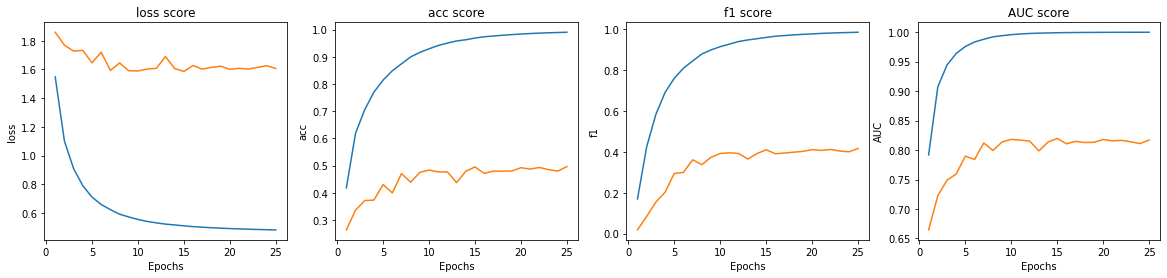

In [156]:
model_hist = history_best.history

labels = [*model_hist.keys()]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
epochs = range(1, len(data_list1[0]) + 1)
for data, label in zip(
    [model_hist["loss"], model_hist["val_loss"]], [labels[0], labels[4]]
):
    axes[0].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["accuracy"], model_hist["val_accuracy"]], [labels[1], labels[5]]
):
    axes[1].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["f1"], model_hist["val_f1"]], [labels[2], labels[6]]
):
    axes[2].plot(epochs, data, label=label)

for data, label in zip(
    [model_hist["auc"], model_hist["val_auc"]], [labels[3], labels[7]]
):
    axes[3].plot(epochs, data, label=label)

for i, label in zip(range(4), ["loss", "acc", "f1", "AUC"]):
    axes[i].set_title(label + " score")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel(label)

In [ ]:
# Save model performance to json file
with open('data/LSTM_modelperformancev3.json', 'w') as fp:
    json.dump(model_hist, fp)

## Calculate precision score with SKlearn

In [146]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score

In [159]:
# Do predictions on test set
val_predv2 = v2.predict(seq_val_features, verbose=0)

# Reshape back to (frame, label)
val_predv2 = np.reshape(
    val_predv2, (val_predv2.shape[0] * val_predv2.shape[1], val_predv2.shape[2])
)

# Convert one hot encoding to integers
val_predv2 = np.argmax(val_predv2, axis=1)

In [160]:
# Reshape back to (frame, label)
val_true = np.reshape(
    seq_val_labels, (seq_val_labels.shape[0] * seq_val_labels.shape[1], seq_val_labels.shape[2])
)
val_true = np.argmax(val_true, axis=1)

In [155]:
# F1 Results with model v3
for avg in [None,  'micro', 'macro', 'weighted']:
    score = f1_score(val_true, val_predv3, average=avg)
    print(f'Average method: {avg}, f1-score: {score}' )

Average method: None, f1-score: [0.65565898 0.08530259 0.00481992 0.03368684 0.36151683 0.13236689
 0.36403782]
Average method: micro, f1-score: 0.49656641604010027
Average method: macro, f1-score: 0.23391284051967842
Average method: weighted, f1-score: 0.4787468545223154


## Plot the model architecture

In [ ]:
# Plot CNN-LSTM model
tf.keras.utils.plot_model(
    cnn_rnn_LSTM,
    to_file="images/best_CNN-LSTM_model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Save model+weights to folder

In [ ]:
# Save model
tf.keras.Model.save(cnn_rnn_LSTM, filepath="data/CNN-LSTM_model.h5")

# Predict on test set

In [10]:
# Load best CNN-LSTM model
best_LSTM = tf.keras.models.load_model(
    filepath="data/CNN-LSTM_model.h5", custom_objects={"F1-metric": f1}, compile=False
)

In [5]:
# Do predictions on test set
test_pred = best_LSTM.predict(seq_test_features, verbose=0)

# Reshape back to (frame, label)
test_pred = np.reshape(
    test_pred, (test_pred.shape[0] * test_pred.shape[1], test_pred.shape[2])
)

# Convert one hot encoding to integers
test_pred = np.argmax(test_pred, axis=1)

In [6]:
# Read test set frames filenames
with open("data/test_filenames.txt", "r") as fp:
    test_filenames = fp.read().splitlines()

# Read AW2 video shapes to grab the length of each video
with open("data/AW2_video_shapes_woext.json", "r") as fp:
    AW2_video_shapes = json.load(fp)

In [37]:
# Puts all test_video_names from test set in list
test_videos = []
for fn in test_filenames:
    video, frame_n = fn.split("\\")
    test_videos.append(video)
test_videos = list(set(test_videos))

# Create text file for each video with first line set to all classes in text
for video in test_videos:
    with open(join("data/test_preds_LSTM/", video + ".txt"), "w") as fp:
        fp.write("Neutral,Anger,Disgust,Fear,Happiness,Sadness,Surprise")

current_video = ""
previous_frame_n = -1
current_frame_n = 0


for fn, label in zip(test_filenames, test_pred):
    # Convert label to string
    label = str(label)

    # Split filename into videoname and frame_n
    video, frame_n = fn.split("\\")
    frame_n = int(frame_n.strip(".jpg"))

    previous_frame_n = current_frame_n
    current_frame_n = frame_n

    # If we moved to the next video, check if the previous videos frame_n was
    # equal to the total amount of frames of the video. If it wasn't, write to
    # all the missing lines -1
    if current_video != video:
        if current_video != "":
            fullvideo = current_video.replace("_left", "").replace("_right", "")
            video_length = AW2_video_shapes.get(fullvideo)
            video_length = video_length[0]

            print(
                f"Current video: {current_video}, diff: {video_length - previous_frame_n}"
            )

            if previous_frame_n != video_length:
                diff = video_length - previous_frame_n
                with open(
                    join("data/test_preds_LSTM/", current_video + ".txt"), "a"
                ) as fp:
                    for i in range(diff):
                        fp.write("\n" + "-1")
        current_video = video
        previous_frame_n = 0

    # Calculate difference between current frame_n and previous one
    diff = current_frame_n - previous_frame_n

    # If frame difference is only 1, then simply write the label on the next line
    if diff == 1:
        with open(join("data/test_preds_LSTM/", video + ".txt"), "a") as fp:
            fp.write("\n" + label)
    # If the frame difference is larger than 1, simply fill the missing lines with -1, and then write the label
    else:
        with open(join("data/test_preds_LSTM/", video + ".txt"), "a") as fp:
            for i in range(diff - 1):
                fp.write("\n" + "-1")
            fp.write("\n" + label)

Current video: 122-60-1920x1080-5, diff: -1
Current video: 126-30-1080x1920, diff: 0
Current video: 130-25-1280x720_left, diff: -1
Current video: 130-25-1280x720_right, diff: -1
Current video: 134-30-1280x720, diff: 0
Current video: 136-30-1920x1080, diff: 47
Current video: 14-30-1920x1080, diff: -1
Current video: 16-30-1920x1080, diff: -1
Current video: 166, diff: -1
Current video: 167, diff: -1
Current video: 168, diff: -1
Current video: 169, diff: -1
Current video: 171, diff: -1
Current video: 172, diff: -1
Current video: 175, diff: -1
Current video: 176, diff: -1
Current video: 177, diff: -1
Current video: 178, diff: -1
Current video: 179, diff: -1
Current video: 181, diff: -1
Current video: 182, diff: -1
Current video: 183, diff: -1
Current video: 184, diff: -1
Current video: 185, diff: -1
Current video: 186, diff: 3
Current video: 187, diff: -1
Current video: 188, diff: -1
Current video: 189, diff: -1
Current video: 190, diff: -1
Current video: 191, diff: -1
Current video: 192, d

# Build HP tuner model

In [4]:
def build_model(hp):
    hp_optimizer = hp.Choice(
        "optimizer", values=["adam", "rmsprop", "adagrad"], default="adagrad"
    )
    hp_units = hp.Int("units", min_value=256, max_value=2048, step=256, default=256)

    model = Sequential(name="RNN-LSTM")
    model.add(
        layers.InputLayer(
            input_shape=(seq_train_features.shape[1], seq_train_features.shape[2])
        )
    )
    model.add(layers.LSTM(hp_units, return_sequences=True, name="LSTM_1"))
    model.add(layers.LayerNormalization())
    model.add(layers.LSTM(256, return_sequences=True, name="LSTM_2"))
    model.add(layers.Dense(7, activation="softmax", name="Dense_Output"))
    model.compile(
        optimizer=hp_optimizer,
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", f1, "AUC"],
    )
    return model

## Hyperparameter tuning

In [10]:
# Keras-tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=48,
    executions_per_trial=1,
    seed=1337,
    project_name="Tuner_search",
    overwrite=True,
)

# Check the defined hyperparameter search space
tuner.search_space_summary()

# Set early stoppping to patience 4
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=4)

# Do random serach for optimal hyperparameters
tuner.search(
    seq_train_features,
    seq_train_labels,
    sample_weight=train_samples_weights,
    epochs=100,
    validation_data=(seq_val_features, seq_val_labels),
    callbacks=[es],
    verbose=2,
)

Epoch 1/100
193/193 - 22s - loss: 1.5836 - accuracy: 0.3760 - f1: 0.1041 - auc: 0.7735 - val_loss: 1.7724 - val_accuracy: 0.3374 - val_f1: 0.0067 - val_auc: 0.7179
Epoch 2/100
193/193 - 19s - loss: 1.1779 - accuracy: 0.5765 - f1: 0.2929 - auc: 0.8914 - val_loss: 1.7605 - val_accuracy: 0.3404 - val_f1: 0.0237 - val_auc: 0.7298
Epoch 3/100
193/193 - 19s - loss: 1.0008 - accuracy: 0.6585 - f1: 0.4434 - auc: 0.9278 - val_loss: 1.7011 - val_accuracy: 0.3910 - val_f1: 0.0682 - val_auc: 0.7589
Epoch 4/100
193/193 - 20s - loss: 0.8886 - accuracy: 0.7067 - f1: 0.5542 - auc: 0.9464 - val_loss: 1.6432 - val_accuracy: 0.4281 - val_f1: 0.1653 - val_auc: 0.7861
Epoch 5/100
193/193 - 20s - loss: 0.8093 - accuracy: 0.7475 - f1: 0.6427 - auc: 0.9600 - val_loss: 1.6677 - val_accuracy: 0.4171 - val_f1: 0.1482 - val_auc: 0.7771
Epoch 6/100
193/193 - 20s - loss: 0.7512 - accuracy: 0.7767 - f1: 0.6984 - auc: 0.9684 - val_loss: 1.6874 - val_accuracy: 0.3986 - val_f1: 0.1740 - val_auc: 0.7738
Epoch 7/100
193/

Epoch 1/100
193/193 - 16s - loss: 1.6588 - accuracy: 0.3228 - f1: 0.0569 - auc: 0.7195 - val_loss: 1.8477 - val_accuracy: 0.2698 - val_f1: 0.0042 - val_auc: 0.6689
Epoch 2/100
193/193 - 13s - loss: 1.2924 - accuracy: 0.5113 - f1: 0.1902 - auc: 0.8600 - val_loss: 1.7457 - val_accuracy: 0.3552 - val_f1: 0.0281 - val_auc: 0.7341
Epoch 3/100
193/193 - 14s - loss: 1.1305 - accuracy: 0.5924 - f1: 0.3063 - auc: 0.8990 - val_loss: 1.7175 - val_accuracy: 0.3680 - val_f1: 0.0550 - val_auc: 0.7516
Epoch 4/100
193/193 - 13s - loss: 1.0212 - accuracy: 0.6448 - f1: 0.4117 - auc: 0.9225 - val_loss: 1.8114 - val_accuracy: 0.3051 - val_f1: 0.0689 - val_auc: 0.7107
Epoch 5/100
193/193 - 13s - loss: 0.9378 - accuracy: 0.6741 - f1: 0.4907 - auc: 0.9344 - val_loss: 1.7007 - val_accuracy: 0.3820 - val_f1: 0.1411 - val_auc: 0.7635
Epoch 6/100
193/193 - 14s - loss: 0.8707 - accuracy: 0.7160 - f1: 0.5728 - auc: 0.9482 - val_loss: 1.6925 - val_accuracy: 0.3852 - val_f1: 0.1803 - val_auc: 0.7703
Epoch 7/100
193/

Epoch 1/100
193/193 - 23s - loss: 1.8052 - accuracy: 0.3571 - f1: 0.1670 - auc: 0.7668 - val_loss: 2.6531 - val_accuracy: 0.1815 - val_f1: 0.1622 - val_auc: 0.5391
Epoch 2/100
193/193 - 20s - loss: 1.3595 - accuracy: 0.5895 - f1: 0.4755 - auc: 0.8781 - val_loss: 1.8803 - val_accuracy: 0.2684 - val_f1: 0.1003 - val_auc: 0.7066
Epoch 3/100
193/193 - 19s - loss: 1.1868 - accuracy: 0.6496 - f1: 0.5893 - auc: 0.9136 - val_loss: 1.7602 - val_accuracy: 0.5071 - val_f1: 0.4535 - val_auc: 0.7995
Epoch 4/100
193/193 - 20s - loss: 1.0980 - accuracy: 0.6809 - f1: 0.6413 - auc: 0.9287 - val_loss: 1.6485 - val_accuracy: 0.5123 - val_f1: 0.4271 - val_auc: 0.7980
Epoch 5/100
193/193 - 20s - loss: 0.9984 - accuracy: 0.7244 - f1: 0.6962 - auc: 0.9439 - val_loss: 1.8862 - val_accuracy: 0.4033 - val_f1: 0.3540 - val_auc: 0.7633
Epoch 6/100
193/193 - 22s - loss: 0.9443 - accuracy: 0.7425 - f1: 0.7201 - auc: 0.9517 - val_loss: 2.3601 - val_accuracy: 0.3121 - val_f1: 0.2535 - val_auc: 0.6625
Epoch 7/100
193/

Epoch 1/100
193/193 - 17s - loss: 1.6789 - accuracy: 0.4316 - f1: 0.2166 - auc: 0.8047 - val_loss: 2.0905 - val_accuracy: 0.2005 - val_f1: 0.1705 - val_auc: 0.7544
Epoch 2/100
193/193 - 14s - loss: 1.3058 - accuracy: 0.6080 - f1: 0.4952 - auc: 0.8923 - val_loss: 1.6684 - val_accuracy: 0.4682 - val_f1: 0.2842 - val_auc: 0.7718
Epoch 3/100
193/193 - 14s - loss: 1.1705 - accuracy: 0.6603 - f1: 0.5983 - auc: 0.9182 - val_loss: 1.7846 - val_accuracy: 0.4365 - val_f1: 0.3515 - val_auc: 0.7689
Epoch 4/100
193/193 - 14s - loss: 1.0638 - accuracy: 0.6942 - f1: 0.6458 - auc: 0.9340 - val_loss: 1.8170 - val_accuracy: 0.3981 - val_f1: 0.3075 - val_auc: 0.7412
Epoch 5/100
193/193 - 14s - loss: 1.0042 - accuracy: 0.7202 - f1: 0.6869 - auc: 0.9430 - val_loss: 1.9865 - val_accuracy: 0.3580 - val_f1: 0.3091 - val_auc: 0.7522
Epoch 6/100
193/193 - 14s - loss: 0.9616 - accuracy: 0.7379 - f1: 0.7112 - auc: 0.9506 - val_loss: 2.0019 - val_accuracy: 0.4001 - val_f1: 0.3401 - val_auc: 0.7220
Epoch 00006: ear

Epoch 1/100
193/193 - 16s - loss: 1.6432 - accuracy: 0.4063 - f1: 0.1704 - auc: 0.7895 - val_loss: 1.6242 - val_accuracy: 0.4634 - val_f1: 0.1715 - val_auc: 0.7882
Epoch 2/100
193/193 - 14s - loss: 1.2727 - accuracy: 0.5933 - f1: 0.4627 - auc: 0.8896 - val_loss: 1.8725 - val_accuracy: 0.3480 - val_f1: 0.1883 - val_auc: 0.7136
Epoch 3/100
193/193 - 14s - loss: 1.1577 - accuracy: 0.6350 - f1: 0.5518 - auc: 0.9105 - val_loss: 2.0791 - val_accuracy: 0.2695 - val_f1: 0.1793 - val_auc: 0.6696
Epoch 4/100
193/193 - 13s - loss: 1.0481 - accuracy: 0.6766 - f1: 0.6302 - auc: 0.9298 - val_loss: 1.9031 - val_accuracy: 0.3335 - val_f1: 0.2673 - val_auc: 0.7434
Epoch 5/100
193/193 - 14s - loss: 0.9767 - accuracy: 0.6954 - f1: 0.6574 - auc: 0.9384 - val_loss: 1.7684 - val_accuracy: 0.3848 - val_f1: 0.3114 - val_auc: 0.7799
Epoch 00005: early stopping


Epoch 1/100
193/193 - 18s - loss: 1.6265 - accuracy: 0.4211 - f1: 0.2060 - auc: 0.7980 - val_loss: 1.6753 - val_accuracy: 0.3652 - val_f1: 0.0827 - val_auc: 0.7708
Epoch 2/100
193/193 - 16s - loss: 1.2703 - accuracy: 0.5782 - f1: 0.4713 - auc: 0.8879 - val_loss: 2.0740 - val_accuracy: 0.2494 - val_f1: 0.1351 - val_auc: 0.6582
Epoch 3/100
193/193 - 16s - loss: 1.1497 - accuracy: 0.6432 - f1: 0.5753 - auc: 0.9165 - val_loss: 1.9864 - val_accuracy: 0.2870 - val_f1: 0.1798 - val_auc: 0.6998
Epoch 4/100
193/193 - 16s - loss: 1.0841 - accuracy: 0.6770 - f1: 0.6251 - auc: 0.9297 - val_loss: 1.8017 - val_accuracy: 0.4335 - val_f1: 0.3430 - val_auc: 0.7548
Epoch 5/100
193/193 - 16s - loss: 0.9683 - accuracy: 0.7127 - f1: 0.6880 - auc: 0.9438 - val_loss: 1.7761 - val_accuracy: 0.4178 - val_f1: 0.3558 - val_auc: 0.7719
Epoch 00005: early stopping


Epoch 1/100
193/193 - 16s - loss: 1.7246 - accuracy: 0.2970 - f1: 0.0220 - auc: 0.6972 - val_loss: 1.8932 - val_accuracy: 0.2137 - val_f1: 4.5855e-04 - val_auc: 0.6305
Epoch 2/100
193/193 - 13s - loss: 1.4097 - accuracy: 0.4587 - f1: 0.1128 - auc: 0.8283 - val_loss: 1.7692 - val_accuracy: 0.2997 - val_f1: 0.0078 - val_auc: 0.7241
Epoch 3/100
193/193 - 15s - loss: 1.2525 - accuracy: 0.5430 - f1: 0.2075 - auc: 0.8770 - val_loss: 1.7587 - val_accuracy: 0.3122 - val_f1: 0.0219 - val_auc: 0.7300
Epoch 4/100
193/193 - 46s - loss: 1.1458 - accuracy: 0.5906 - f1: 0.2888 - auc: 0.8995 - val_loss: 1.7181 - val_accuracy: 0.3556 - val_f1: 0.0399 - val_auc: 0.7520
Epoch 5/100
193/193 - 55s - loss: 1.0613 - accuracy: 0.6287 - f1: 0.3690 - auc: 0.9154 - val_loss: 1.7016 - val_accuracy: 0.3668 - val_f1: 0.0661 - val_auc: 0.7608
Epoch 6/100
193/193 - 41s - loss: 0.9925 - accuracy: 0.6523 - f1: 0.4392 - auc: 0.9269 - val_loss: 1.6724 - val_accuracy: 0.3895 - val_f1: 0.1022 - val_auc: 0.7744
Epoch 7/100


Epoch 1/100
193/193 - 32s - loss: 1.7692 - accuracy: 0.3699 - f1: 0.1756 - auc: 0.7760 - val_loss: 1.6378 - val_accuracy: 0.4602 - val_f1: 0.0764 - val_auc: 0.7851
Epoch 2/100
193/193 - 32s - loss: 1.3465 - accuracy: 0.5903 - f1: 0.4789 - auc: 0.8837 - val_loss: 1.5878 - val_accuracy: 0.4803 - val_f1: 0.3234 - val_auc: 0.8048
Epoch 3/100
193/193 - 32s - loss: 1.1666 - accuracy: 0.6596 - f1: 0.5964 - auc: 0.9160 - val_loss: 1.6979 - val_accuracy: 0.4699 - val_f1: 0.3871 - val_auc: 0.7869
Epoch 4/100
193/193 - 33s - loss: 1.0995 - accuracy: 0.6933 - f1: 0.6481 - auc: 0.9299 - val_loss: 1.6996 - val_accuracy: 0.4304 - val_f1: 0.3262 - val_auc: 0.7841
Epoch 5/100
193/193 - 29s - loss: 1.0089 - accuracy: 0.7112 - f1: 0.6821 - auc: 0.9407 - val_loss: 1.6991 - val_accuracy: 0.4584 - val_f1: 0.3905 - val_auc: 0.8016
Epoch 6/100
193/193 - 29s - loss: 0.9517 - accuracy: 0.7484 - f1: 0.7263 - auc: 0.9547 - val_loss: 1.8981 - val_accuracy: 0.4307 - val_f1: 0.3708 - val_auc: 0.7411
Epoch 00006: ear

Epoch 1/100
193/193 - 29s - loss: 1.6081 - accuracy: 0.3852 - f1: 0.0923 - auc: 0.7732 - val_loss: 1.7908 - val_accuracy: 0.3027 - val_f1: 0.0246 - val_auc: 0.6994
Epoch 2/100
193/193 - 25s - loss: 1.2197 - accuracy: 0.5619 - f1: 0.2673 - auc: 0.8827 - val_loss: 1.7364 - val_accuracy: 0.3481 - val_f1: 0.0631 - val_auc: 0.7370
Epoch 3/100
193/193 - 31s - loss: 1.0505 - accuracy: 0.6423 - f1: 0.4051 - auc: 0.9195 - val_loss: 1.7437 - val_accuracy: 0.3427 - val_f1: 0.1006 - val_auc: 0.7340
Epoch 4/100
193/193 - 21s - loss: 0.9357 - accuracy: 0.6890 - f1: 0.5094 - auc: 0.9379 - val_loss: 1.6318 - val_accuracy: 0.4148 - val_f1: 0.1741 - val_auc: 0.7857
Epoch 5/100
193/193 - 17s - loss: 0.8549 - accuracy: 0.7338 - f1: 0.6003 - auc: 0.9526 - val_loss: 2.0361 - val_accuracy: 0.2284 - val_f1: 0.1181 - val_auc: 0.6577
Epoch 6/100
193/193 - 17s - loss: 0.8021 - accuracy: 0.7501 - f1: 0.6484 - auc: 0.9581 - val_loss: 1.6404 - val_accuracy: 0.4129 - val_f1: 0.2047 - val_auc: 0.7879
Epoch 7/100
193/

Epoch 1/100
193/193 - 16s - loss: 1.6071 - accuracy: 0.4214 - f1: 0.1973 - auc: 0.8006 - val_loss: 1.8729 - val_accuracy: 0.2485 - val_f1: 0.0550 - val_auc: 0.6816
Epoch 2/100
193/193 - 13s - loss: 1.2650 - accuracy: 0.5686 - f1: 0.4503 - auc: 0.8805 - val_loss: 2.0419 - val_accuracy: 0.2862 - val_f1: 0.0750 - val_auc: 0.6404
Epoch 3/100
193/193 - 13s - loss: 1.1008 - accuracy: 0.6425 - f1: 0.5846 - auc: 0.9163 - val_loss: 1.8266 - val_accuracy: 0.3752 - val_f1: 0.2340 - val_auc: 0.7342
Epoch 4/100
193/193 - 13s - loss: 1.0308 - accuracy: 0.6784 - f1: 0.6321 - auc: 0.9314 - val_loss: 2.0768 - val_accuracy: 0.2499 - val_f1: 0.1511 - val_auc: 0.6627
Epoch 5/100
193/193 - 13s - loss: 1.0002 - accuracy: 0.6788 - f1: 0.6406 - auc: 0.9324 - val_loss: 1.7483 - val_accuracy: 0.4595 - val_f1: 0.3870 - val_auc: 0.7853
Epoch 6/100
193/193 - 13s - loss: 0.9494 - accuracy: 0.7184 - f1: 0.6931 - auc: 0.9433 - val_loss: 1.8333 - val_accuracy: 0.3880 - val_f1: 0.3023 - val_auc: 0.7685
Epoch 7/100
193/

Epoch 1/100
193/193 - 24s - loss: 1.6572 - accuracy: 0.3921 - f1: 0.1706 - auc: 0.7914 - val_loss: 2.0401 - val_accuracy: 0.1682 - val_f1: 0.0369 - val_auc: 0.6058
Epoch 2/100
193/193 - 21s - loss: 1.2794 - accuracy: 0.5870 - f1: 0.4666 - auc: 0.8904 - val_loss: 1.6296 - val_accuracy: 0.4755 - val_f1: 0.3438 - val_auc: 0.8003
Epoch 3/100
193/193 - 20s - loss: 1.1613 - accuracy: 0.6504 - f1: 0.5747 - auc: 0.9136 - val_loss: 2.0009 - val_accuracy: 0.2820 - val_f1: 0.1592 - val_auc: 0.6955
Epoch 4/100
193/193 - 22s - loss: 1.0400 - accuracy: 0.6932 - f1: 0.6498 - auc: 0.9350 - val_loss: 1.6556 - val_accuracy: 0.4751 - val_f1: 0.3912 - val_auc: 0.8089
Epoch 5/100
193/193 - 20s - loss: 0.9901 - accuracy: 0.7169 - f1: 0.6908 - auc: 0.9450 - val_loss: 1.6590 - val_accuracy: 0.4401 - val_f1: 0.3422 - val_auc: 0.8088
Epoch 6/100
193/193 - 22s - loss: 0.8953 - accuracy: 0.7503 - f1: 0.7372 - auc: 0.9568 - val_loss: 1.9384 - val_accuracy: 0.3785 - val_f1: 0.3321 - val_auc: 0.7597
Epoch 00006: ear

INFO:tensorflow:Oracle triggered exit


# Build optimal HP model

In [11]:
tuner.results_summary()

In [12]:
## Grab optimal hyperparameter
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'optimizer': 'adagrad', 'units': 768}